# Tracing Basics

### Setup

Make sure you set your environment variables, including your OpenAI API key.

In [ ]:
# You can set them inline
import os
os.environ["OPENAI_API_KEY"] = ""
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langsmith-academy"

In [ ]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv(dotenv_path="C:/Users/hp/Desktop/CODING/AkshitBaliyan-langsmith-Mat496/AkshitBaliyan-langsmith-MAT496/.env", override=True)

True

### Tracing with @traceable

The @traceable decorator is a simple way to log traces from the LangSmith Python SDK. Simply decorate any function with @traceable.

The decorator works by creating a run tree for you each time the function is called and inserting it within the current trace. The function inputs, name, and other information is then streamed to LangSmith. If the function raises an error or if it returns a response, that information is also added to the tree, and updates are patched to LangSmith so you can detect and diagnose sources of errors. This is all done on a background thread to avoid blocking your app's execution.

In [ ]:
# TODO: Import traceable

from langsmith import traceable
from openai import OpenAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "openai"
MODEL_NAME = "gpt-4o-mini"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

openai_client = OpenAI()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

# TODO: Set up tracing for each function
@traceable
def retrieve_documents(question: str):
    return retriever.invoke(question)   # NOTE: This is a LangChain vector db retriever, so this .invoke() call will be traced automatically

@traceable
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

@traceable
def call_openai(
    messages: List[dict], model: str = MODEL_NAME, temperature: float = 0.0
) -> str:
    return openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )

@traceable
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


@traceable handles the RunTree lifecycle for you!

In [25]:
question = "How can I trace with the @traceable decorator?"
ai_answer = langsmith_rag(question)
print(ai_answer)

To trace with the @traceable decorator in Python, simply decorate any function you want to log traces for with @traceable. Ensure that the LANGSMITH_TRACING environment variable is set to 'true' and the LANGSMITH_API_KEY is configured with your API key. When calling a synchronous function wrapped with @traceable, use the await keyword to ensure the trace is logged correctly.


##### Let's take a look in LangSmith!

### Adding Metadata

LangSmith supports sending arbitrary metadata along with traces.

Metadata is a collection of key-value pairs that can be attached to runs. Metadata can be used to store additional information about a run, such as the version of the application that generated the run, the environment in which the run was generated, or any other information that you want to associate with a run. Similar to tags, you can use metadata to filter runs in the LangSmith UI, and can be used to group runs together for analysis.

In [29]:
#from langsmith import traceable

@traceable(
    metadata={"vectordb": "sklearn"}
)
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable(
    metadata={"content":RAG_SYSTEM_PROMPT}
)
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

@traceable(
    metadata={"model_name": MODEL_NAME, "model_provider": MODEL_PROVIDER}
)
def call_openai(
    messages: List[dict], model: str = MODEL_NAME, temperature: float = 0.0
) -> str:
    return openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )

@traceable
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


In [30]:
question = "How do I add Metadata to a Run with @traceable?"
ai_answer = langsmith_rag(question)
print(ai_answer)

You can add metadata to a run by including a metadata key in the `experimental_telemetry` object when calling the `generateText` function. For example, you can pass metadata like `{ userId: "123", language: "english" }` within the `experimental_telemetry` parameter. This metadata will then be visible in your LangSmith dashboard and can be used for filtering and searching traces.


You can also add metadata at runtime!

In [31]:
question = "How do I add metadata at runtime?"
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"runtime_key": "runtime_value"}})
print(ai_answer)

To add metadata at runtime, you can attach it when you run an experiment in the SDK. This involves specifying the metadata related to your experiment, such as the model used or other relevant identifiers. Ensure that the same metadata is also attached to the trace for consistent filtering and analysis later.


##### Let's take a look in LangSmith!

The below image showcases the changes observed in the langsmith website

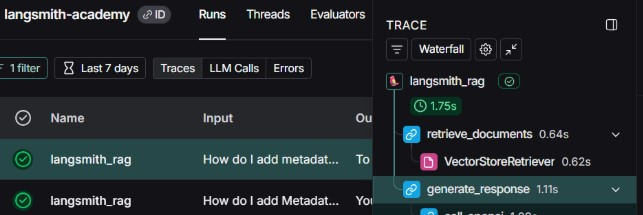 